In [ ]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim

data = pd.read_csv("protein_data.tsv.gz", sep="\t")
data = data[data["Length"] <= 256] # removes all proteins with a length > 256
# Reduce EC number to 3 digits to decrease data size
data = data.dropna(subset=['EC number']).assign(
    ec_number_reduced = lambda x: x['EC number'].str.split(".").str[:3].str.join(".")
)

# Filter out EC numbers with frequency less than 100
ec_number_counts = data["ec_number_reduced"].value_counts()
data = data[data["ec_number_reduced"].isin(ec_number_counts[ec_number_counts >= 100].index)]

<ipython-input-1-9ddc276f201b>:10: DtypeWarning: Columns (12,15,16,18,19,21,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("protein_data.tsv.gz", sep="\t")


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

encoder = OneHotEncoder(sparse=False)
encoded_column = encoder.fit_transform(data[["ec_number_reduced"]])

# Split data into 80% training data and 20% testing data
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

train_labels = encoded_column[:train_size]
test_labels = encoded_column[train_size:]

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
train_dataset = CustomDataset(train_data["Sequence"].tolist(), train_labels)
test_dataset = CustomDataset(test_data["Sequence"].tolist(), test_labels)

# Used to combine data into batches
def collate_fn(batch):
    proteins = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return tokenizer(proteins, padding=True), torch.tensor(labels)

batch_size = 8
# Put data into batches
train_dataloader = DataLoader(train_dataset, batch_size, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, collate_fn=collate_fn, shuffle=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

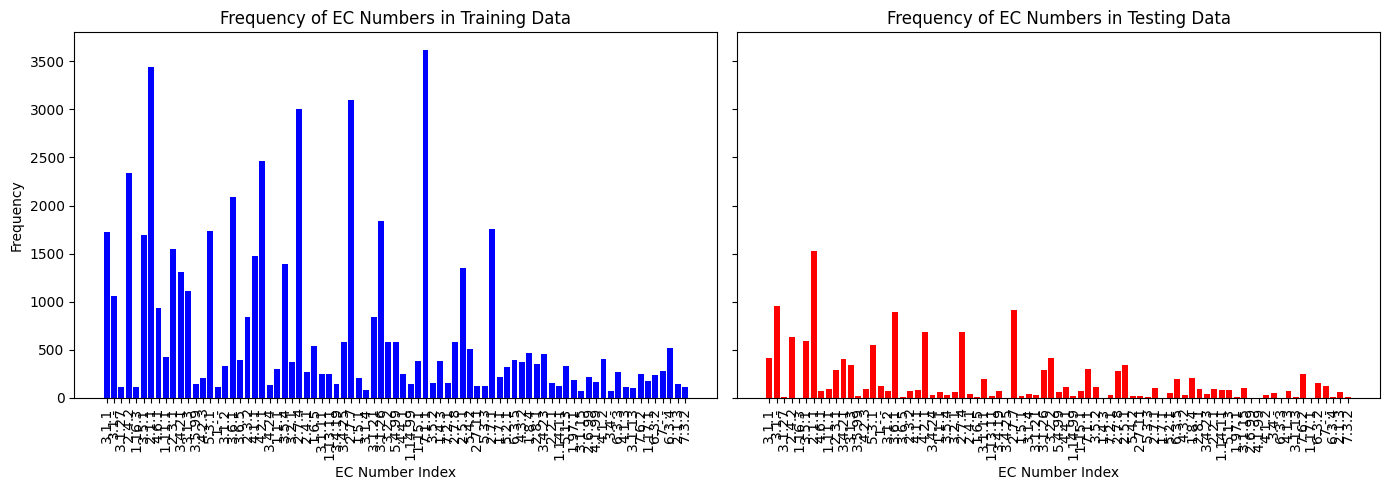

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

ec_number_to_index = {ec_number: idx for idx, ec_number in enumerate(data["ec_number_reduced"].unique())}
index_to_ec_number = {idx: ec_number for ec_number, idx in ec_number_to_index.items()}

train_indices = train_data["ec_number_reduced"].map(ec_number_to_index)
test_indices = test_data["ec_number_reduced"].map(ec_number_to_index)

train_freq = Counter(train_indices)
test_freq = Counter(test_indices)

train_freq_sorted = [train_freq[i] for i in range(len(ec_number_to_index))]
test_freq_sorted = [test_freq[i] for i in range(len(ec_number_to_index))]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

axes[0].bar(range(len(ec_number_to_index)), train_freq_sorted, color="b")
axes[0].set_title("Frequency of EC Numbers in Training Data")
axes[0].set_xlabel("EC Number Index")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks(range(len(ec_number_to_index)))
axes[0].set_xticklabels([index_to_ec_number[i] for i in range(len(ec_number_to_index))], rotation=90)

axes[1].bar(range(len(ec_number_to_index)), test_freq_sorted, color="r")
axes[1].set_title("Frequency of EC Numbers in Testing Data")
axes[1].set_xlabel("EC Number Index")
axes[1].set_xticks(range(len(ec_number_to_index)))
axes[1].set_xticklabels([index_to_ec_number[i] for i in range(len(ec_number_to_index))], rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
class MyModel(nn.Module):
    def __init__(self, esm_model, num_classes):
        super(MyModel, self).__init__()
        self.esm_model = esm_model
        for param in self.esm_model.parameters():
            param.requires_grad = False
        # Four layers: 320, 200, 128, num_classes
        self.fc_layers = nn.Sequential(nn.Linear(320, 200),
                                       nn.ReLU(),
                                       nn.Linear(200, 128),
                                       nn.ReLU(),
                                       nn.Linear(128, num_classes))

    def forward(self, input_ids, attention_mask):
        outputs = self.esm_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        pool = torch.mean(outputs.hidden_states[-1], dim=1)
        logits = self.fc_layers(pool)
        probs = torch.softmax(logits, dim=1)
        return logits, probs

num_classes = len(set(data["ec_number_reduced"].tolist()))
esm_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = MyModel(esm_model, num_classes).to("cuda")

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Assign weight to each EC number

ec_number_freq = train_data['ec_number_reduced'].value_counts()
ec_number_to_index = {ec_number: idx for idx, ec_number in enumerate(train_data['ec_number_reduced'].unique())}

full_weights = torch.ones(len(ec_number_to_index)).float()
for ec_number, count in ec_number_freq.items():
    if ec_number in ec_number_to_index:
        index = ec_number_to_index[ec_number]
        full_weights[index] = 1.0 / count
full_weights /= full_weights.min()  # Normalize weights

weight_tensor = full_weights.to('cuda')

loss_function = nn.CrossEntropyLoss(weight=weight_tensor)

learning_rate = 0.0001
epochs = 100
early_stop_count = 5
min_loss_improvement = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
accuracies = []
top_5_accuracies = []

best_loss = float("inf")
no_improvement_count = 0

# Load model from checkpoint
current_epoch = 55
checkpoint = torch.load(f'/content/drive/My Drive/Protein Function ESM/checkpoint_epoch_{current_epoch}.pth')
model = MyModel(esm_model, num_classes).to('cuda')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

for epoch in range(current_epoch, epochs):
    model.train()
    total_loss = 0
    for batch in tqdm.tqdm(train_dataloader):
        inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
        attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
        labels = batch[1].to("cuda")

        optimizer.zero_grad()
        logits, probs = model(inputs, attention_masks)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch}, loss: {average_loss:.4f}")
    losses.append(average_loss)

    # Accuracy
    model.eval()

    correct = 0
    total = 0
    top_5_correct = 0
    top_5_total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
            attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
            labels = batch[1].to("cuda")

            # Top-1 Accuracy
            logits, probs = model(inputs, attention_masks)
            pred_class = probs.argmax(-1).flatten()
            labels = labels.argmax(-1).flatten()
            correct += (pred_class == labels).sum().item()
            total += pred_class.shape[0]

            # Top-5 Accuracy
            pred_classes = probs.topk(5, dim=1)[1]

            for i in range(pred_classes.shape[0]):
                if labels[i] in pred_classes[i]:
                    top_5_correct += 1
                top_5_total += 1

    accuracy = correct / total * 100
    top_5_accuracy = top_5_correct / top_5_total * 100
    accuracies.append(accuracy)
    top_5_accuracies.append(accuracy)

    if best_loss - average_loss > min_loss_improvement:
        best_loss = average_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stop_count:
        break

    if epoch > 50:
        checkpoint = {
            "epoch": epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss.item()
        }

        torch.save(checkpoint, f"/content/drive/My Drive/Protein Function ESM/checkpoint_epoch_{epoch+1}.pth")

100%|██████████| 6999/6999 [03:23<00:00, 34.43it/s]


Epoch 55, loss: 0.3403


100%|██████████| 6999/6999 [03:23<00:00, 34.46it/s]


Epoch 56, loss: 0.3379


100%|██████████| 6999/6999 [03:23<00:00, 34.40it/s]


Epoch 57, loss: 0.3301


100%|██████████| 6999/6999 [03:22<00:00, 34.60it/s]


Epoch 58, loss: 0.3260


100%|██████████| 6999/6999 [03:22<00:00, 34.52it/s]


Epoch 59, loss: 0.3371


100%|██████████| 6999/6999 [03:23<00:00, 34.46it/s]


Epoch 60, loss: 0.3347


100%|██████████| 6999/6999 [03:22<00:00, 34.53it/s]


Epoch 61, loss: 0.3339


100%|██████████| 6999/6999 [03:23<00:00, 34.35it/s]


Epoch 62, loss: 0.3327


100%|██████████| 6999/6999 [03:23<00:00, 34.42it/s]


Epoch 63, loss: 0.3336


In [ ]:
model.eval()

correct = 0
total = 0

top_5_correct = 0
top_5_total = 0

class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for batch in tqdm.tqdm(test_dataloader):
        inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
        attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
        labels = batch[1].to("cuda")

        # Top-1 Accuracy
        logits, probs = model(inputs, attention_masks)
        pred_class = probs.argmax(-1).flatten()
        labels = labels.argmax(-1).flatten()
        correct += (pred_class == labels).sum().item()
        total += pred_class.shape[0]

        # Top-5 Accuracy
        pred_classes = probs.topk(5, dim=1)[1]

        for i in range(pred_classes.shape[0]):
            if labels[i] in pred_classes[i]:
                top_5_correct += 1
            top_5_total += 1

        # Accuracy per class
        for i in range(labels.shape[0]):
            class_label = labels[i]
            class_correct[class_label] += (pred_class[i] == class_label).item()
            class_total[class_label] += 1

100%|██████████| 1750/1750 [00:51<00:00, 34.29it/s]


In [ ]:
accuracy = correct / total * 100
top_5_accuracy = top_5_correct / top_5_total * 100
print(f"Accuracy: {accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

highest = 0
highest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] > highest:
            highest = class_correct[i] / class_total[i]
            highest_idx = i

lowest = float("inf")
lowest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] < lowest:
            lowest = class_correct[i] / class_total[i]
            lowest_idx = i

highest_accuracy = highest * 100
lowest_accuracy = lowest * 100
print(f"Highest Accuracy Label: {highest_idx}, Accuracy: {highest_accuracy:.4f}%")
print(f"Lowest Accuracy Label: {lowest_idx}, Accuracy: {lowest_accuracy:.4f}%")

Accuracy: 89.4278
Top-5 Accuracy: 95.7140
Highest Accuracy Label: 5, Accuracy: 100.0000%
Lowest Accuracy Label: 7, Accuracy: 0.0000%


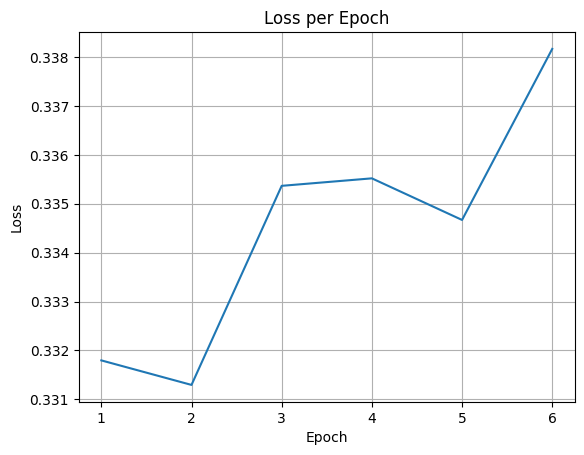

In [ ]:
import matplotlib.pyplot as plt

epochs_lst = list(range(1, len(losses)+1))

plt.plot(epochs_lst, losses)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

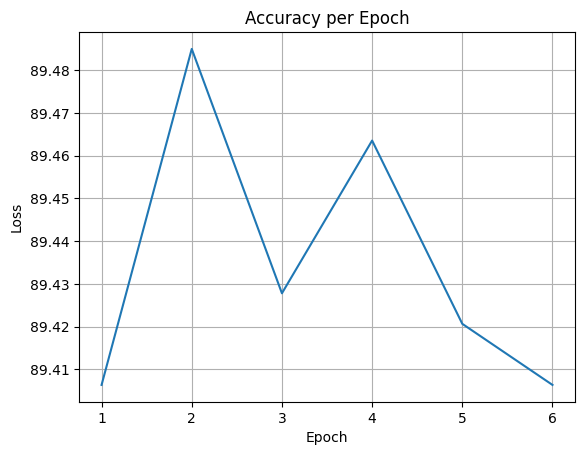

In [ ]:
plt.plot(epochs_lst, accuracies)
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
print(data["ec_number_reduced"].iloc[highest_idx])
print(data["ec_number_reduced"].iloc[lowest_idx])
print(class_total[highest_idx], class_total[lowest_idx])
print()
for i in range(num_classes):
    if class_correct[i] == 0 and class_total[i] != 0:
        print(data["ec_number_reduced"].iloc[i], class_total[i])

3.5.1
2.1.1
23 1

2.1.1 1
3.1.1 34
3.1.1 3


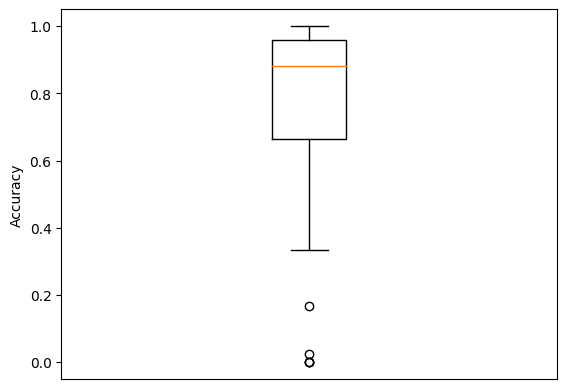

In [ ]:
class_accuracies = [0] * num_classes
for i in range(num_classes):
    if class_total[i] == 0:
        class_accuracies[i] = -1
    else:
        class_accuracies[i] = class_correct[i] / class_total[i]

class_accuracies.sort()
class_accuracies = [x for x in class_accuracies if x != -1]

plt.boxplot(class_accuracies)
plt.xticks([])
plt.ylabel("Accuracy")
plt.show()

In [ ]:
import numpy as np

Q1 = np.percentile(class_accuracies, 25)
Q3 = np.percentile(class_accuracies, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = [x for x in class_accuracies if x < lower_bound or x > upper_bound]

print("Outliers:", outliers)

Outliers: [0.0, 0.0, 0.0, 0.024793388429752067, 0.16666666666666666]
